In [1]:
print("hw")

hw


get representations at first

In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer

before_model_id = "/home/G01-A100-20240605/pretrained_models/Meta-Llama-3-8B-Instruct/"
model_ids = {
    "after_model_id_1": "/mnt/afs/KALE-LM",
    "after_model_id_2": "/mnt/afs/KALE-LM-2",
    "after_model_id_3": "/mnt/afs/dwc/chkpts/sft/llamafy-Llama-3-8B-Instruct_sft_full_241104_v4",
    "after_model_id_4": "/mnt/afs/dwc/chkpts/dpo/Llama-3-8B-Instruct_sft_full_241104_v4-dpo_full_241220_v4_beta4"
}
chosen_id = "after_model_id_4"
after_model_id = model_ids[chosen_id]
compare_model_name = f"_id{chosen_id.split('_')[-1]}"
print(compare_model_name)

/home/dzj/miniforge3/envs/lfvt/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


_id4


In [2]:
tokenizer = AutoTokenizer.from_pretrained(before_model_id)
before_model = AutoModelForCausalLM.from_pretrained(before_model_id, device_map="cuda:0")
after_model = AutoModelForCausalLM.from_pretrained(after_model_id, device_map="cuda:0")

Loading checkpoint shards: 100%|██████████| 4/4 [00:12<00:00,  3.02s/it]


In [3]:
# list(set(tokenizer.batch_encode_plus(["CH4", "CH3", '628', 'Ġvelmi', '.mesh', '.Has', 'Ġspiral'], add_special_tokens=False)['input_ids']))
tokenizer.batch_encode_plus(["CH4", "CH3", '628', 'Ġvelmi', '.mesh', '.Has', 'Ġspiral'], add_special_tokens=False)['input_ids']

[[2198, 19],
 [2198, 18],
 [23574],
 [119741, 899, 8318],
 [44422],
 [16545],
 [119741, 2203, 37478]]

In [4]:
tokenizer.encode(" velmi")

[128000, 105165]

In [4]:
before_vectors = before_model.get_input_embeddings().weight[[1,3,128255,2]].detach().to("cpu").numpy()
import numpy as np
after_vectors = np.empty([1,4096])
print(np.concatenate((before_vectors, after_vectors), axis = 0).shape)
mean = before_vectors.mean(axis=0)
print(np.concatenate((np.expand_dims(mean,axis=0), before_vectors), axis=0).shape)

(5, 4096)
(5, 4096)


In [3]:
import numpy as np
from loguru import logger
def single_molecule_representation(molecule, tokenizer, model, mode):
    assert mode in ["average", "sum"]
    molecule_ids = tokenizer.encode(molecule, add_special_tokens=False)
    molecule_rep = model.get_input_embeddings().weight[molecule_ids].detach().to("cpu").numpy()
    if mode == "average":
        return np.expand_dims(molecule_rep.mean(axis=0), axis=0)  # (1, 4096)
    elif mode == "sum":
        return np.expand_dims(molecule_rep.sum(axis=0), axis=0)
    return None

def get_molecule_vectors(molecules, before_model, after_model=None, tokenizer=tokenizer, mode="average"):
    before_molecule_vectors = np.concatenate(list(map(lambda x: single_molecule_representation(molecule=x, tokenizer=tokenizer, model=before_model, mode=mode), molecules)), axis=0)
    after_molecule_vectors = np.empty([1,4096], object)
    if after_model:
        logger.debug("after model is used")
        after_molecule_vectors = np.concatenate(list(map(lambda x: single_molecule_representation(molecule=x, tokenizer=tokenizer, model=after_model, mode=mode), molecules)), axis=0)
    # return np.concatenate((before_molecule_vectors, after_molecule_vectors), axis=0) if after_molecule_vectors.any() else before_molecule_vectors
    return (before_molecule_vectors, after_molecule_vectors) if after_molecule_vectors.any() else (before_molecule_vectors, None)

def get_other_vectors(token_ids, before_model, after_model=None):
    before_vectors = before_model.get_input_embeddings().weight[token_ids].detach().to("cpu").numpy()
    after_vectors = np.empty([1,4096], object)
    if after_model:
        logger.debug("after model is used")
        after_vectors = after_model.get_input_embeddings().weight[token_ids].detach().to("cpu").numpy()
    # return np.concatenate((before_vectors, after_vectors), axis=0) if after_vectors.any() else before_vectors
    return (before_vectors, after_vectors) if after_vectors.any() else (before_vectors, None)

deepseek建议：分层抽样更有效：

化学领域词（核心分析对象）

相关领域词（如生物学、医学词汇，用于对比邻近领域）

通用高频词（如"the", "and"，用于锚定通用语义区域）

随机词（随机采样的任意词，反映全局分布）

In [9]:
molecule_sample_num = 1000
background_sample_ratio = 1  # background sample : molecule sample


background_sample_num = int(background_sample_ratio*molecule_sample_num)


In [10]:
import json
from random import sample

from tqdm import tqdm

src_data_file = "/home/dzj/data/Compound_000000001_000500000.jsonl"
molecules = []
mode = "average"

with open(src_data_file, "r", encoding="utf8") as f:
    for _ in tqdm(range(molecule_sample_num)):
        molecule_info = json.loads(f.readline())
        if len(molecule_info.keys()) == 1:
            molecule_info = molecule_info[list(molecule_info.keys())[0]]
        else:
            raise KeyError("source file should be like \{'1':\{\}\}, but %f found" % molecule_info)
        molecules.append(molecule_info["Canonical SMILES"])

pre_vectors, post_vectors = get_molecule_vectors(
    molecules=molecules,
    before_model=before_model,
    after_model=after_model,
    tokenizer=tokenizer,
    mode=mode)

if background_sample_num == 0:
    all_vectors = np.vstack((pre_vectors, post_vectors))
else:
    background_ids = sample(range(tokenizer.vocab_size), background_sample_num)
    background_pre_vectors, background_post_vectors = get_other_vectors(
        token_ids=background_ids,
        before_model=before_model,
        after_model=after_model
    )
    logger.debug(f"background before is shape of {background_pre_vectors.shape}, background after is shape of {background_post_vectors.shape}")
    all_vectors = np.vstack((pre_vectors, post_vectors, background_pre_vectors, background_post_vectors))


100%|██████████| 1000/1000 [00:00<00:00, 118798.62it/s]
2025-02-10 18:33:59.157 | DEBUG    | __main__:get_molecule_vectors:17 - after model is used
2025-02-10 18:33:59.513 | DEBUG    | __main__:get_other_vectors:26 - after model is used
2025-02-10 18:33:59.522 | DEBUG    | __main__:<module>:35 - background before is shape of (1000, 4096), background after is shape of (1000, 4096)


# 试试 PCA

In [24]:
from sklearn.decomposition import PCA

print(all_vectors.shape)

pca = PCA(n_components=2)
all_pca = pca.fit_transform(all_vectors)

print(all_pca.shape)

(22000, 4096)
(22000, 2)


# 试试 tSNE

In [11]:
from sklearn.manifold import TSNE

print(all_vectors.shape)

tsne = TSNE(n_components=2, random_state=42)
all_tsne = tsne.fit_transform(all_vectors)

print(all_tsne.shape)

(4000, 4096)
(4000, 2)


画图

In [12]:
import matplotlib.pyplot as plt

def twoD_plot(front_points, background_points=None, savename="default"):
    plt.figure(figsize=(10, 8))
    if background_points is not None:
        plt.scatter(background_points[:, 0], background_points[:, 1], c='grey', label='BG-Points')
    plt.scatter(front_points[:, 0], front_points[:, 1], c='blue', label='Front-Points')
    plt.legend()
    plt.savefig(savename+".png")
    plt.show()

def twoD_plot_comparison(front_points, background_points=None, savename="default"):
    length = front_points.shape[0]//2
    pre_points = front_points[:length]
    post_points = front_points[length:]
    logger.debug(f"length of pre points: {pre_points.shape}, length of post points: {post_points.shape}")
    
    plt.figure(figsize=(10, 8))
    if background_points is not None:
        bg_length = background_points.shape[0]//2
        pre_bg_points = background_points[:bg_length]
        post_bg_points = background_points[bg_length:]
        plt.scatter(pre_bg_points[:, 0], pre_bg_points[:, 1], c='black', label='Pre-BG-Points', alpha=0.6)
        plt.scatter(post_bg_points[:, 0], post_bg_points[:, 1], c='grey', label='Post-BG-Points', alpha=0.6)
    plt.scatter(pre_points[:, 0], pre_points[:, 1], c='blue', label='Pre-Points', alpha=0.6)
    plt.scatter(post_points[:, 0], post_points[:, 1], c='red', label='Post-Points', alpha=0.6)
    # for i in range(length):
    #     plt.plot([pre_points[i, 0], post_points[i, 0]], 
    #             [pre_points[i, 1], post_points[i, 1]], 
    #             'k--', alpha=0.3, linewidth=1)
    # plt.plot([0.1, 0.2], [0.2, 0.3],'k--', alpha=0.3, linewidth=1)
    plt.legend()
    plt.savefig(savename+".png")
    plt.show()

2025-02-10 18:34:45.542 | DEBUG    | __main__:twoD_plot_comparison:16 - length of pre points: (1000, 2), length of post points: (1000, 2)


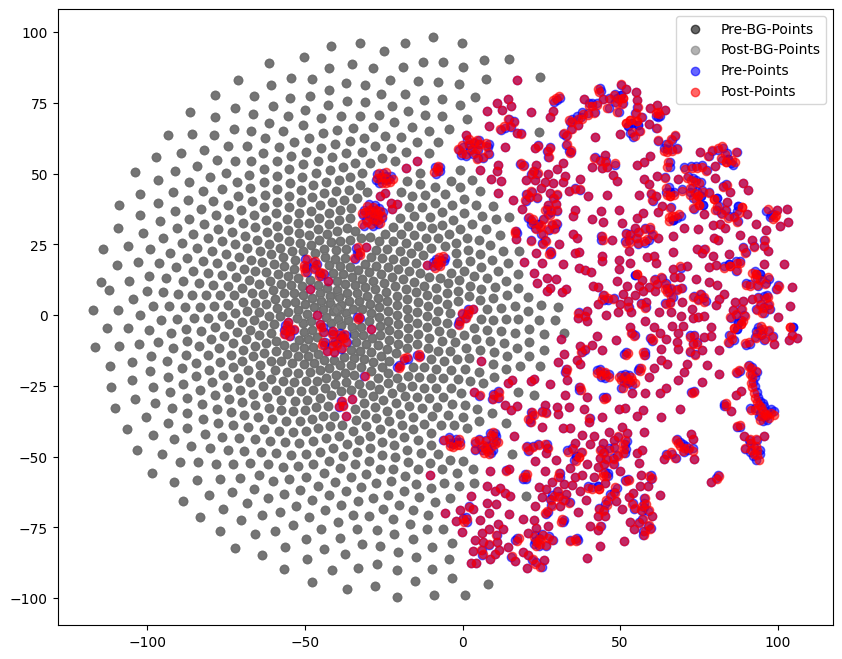

In [13]:
twoD_plot_comparison(front_points=all_tsne[:2*molecule_sample_num], background_points=all_tsne[2*molecule_sample_num:], savename=f"model{compare_model_name}+ratio{background_sample_ratio}+{mode}")